In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
listings = pd.read_csv('listings.csv')

# Section 1: Data Integrity and Cleansing

In [2]:
# The dataset is comprised of 8078 rows and 106 columns.

print('Rows: ', len(listings),'\n'
     'Columns: ', len(listings.columns))

Rows:  8078 
Columns:  106


In [3]:
# With 106 colulmns, it was easiest to manually review and decide what I wanted to remove.

dropCols = ['listing_url','scrape_id','last_scraped','summary','space','neighborhood_overview','notes'
            , 'access','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name'
            , 'host_about','host_thumbnail_url','host_picture_url','host_listings_count','neighbourhood'
            , 'calendar_last_scraped','neighbourhood_group_cleansed','city','state','market','smart_location'
            ,'country_code','country','name', 'description','house_rules']

for x in dropCols:
    del listings[x]

         countNull
count    28.000000
mean   2039.571429
std    2107.937827
min       4.000000
25%     642.250000
50%    1901.000000
75%    1965.000000
max    7968.000000


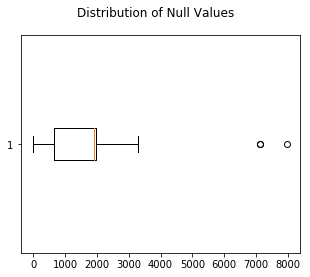

In [4]:
# Checking for incomplete data
# There are 28 columns containing null values. 
# Our quartiles show that the average is being dragged up by the top quartile, which can be seen in the chart below.

incompleteDataResults = []
for i in listings.columns:
    if listings[i].isnull().sum() > 0:
        incompleteDataResults.append((i, listings[i].isnull().sum()))
        
cols = ['columnName', 'countNull']
incompleteDF=(pd.DataFrame(incompleteDataResults, columns = cols))
print(incompleteDF.describe())

plt.rcParams['figure.figsize'] = 5,4
plt.figure().suptitle('Distribution of Null Values')
plt.boxplot(incompleteDF['countNull'], vert=False)
plt.show()

In [5]:
# format date cols

dates = ['host_since', 'first_review', 'last_review']
for x in dates:
    listings[x] = pd.to_datetime(listings[x], format= '%Y-%m-%d')
    
# format percentage cols.

percentages = ['host_response_rate', 'host_acceptance_rate']
for x in percentages:
    listings[x] = pd.to_numeric(listings[x].str.strip('%')).div(100)
    
# format currency cols
currency = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee'
         , 'guests_included','extra_people']
for x in currency:
    listings[x] = listings[x].replace('[\$,]', '', regex=True).astype(float)
    
# format numeric cols
numerics = ['host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds'
          , 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights'
          , 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'
          , 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews'
          , 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness'
          , 'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value'
          , 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes'
          , 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
          , 'reviews_per_month']
for x in numerics:
    listings[x] = listings[x].astype(float)

# format booleans
# for x in bools:
listings = listings.replace(['t', 'f'], [1,0]) 

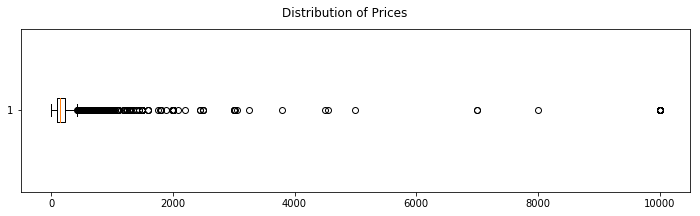

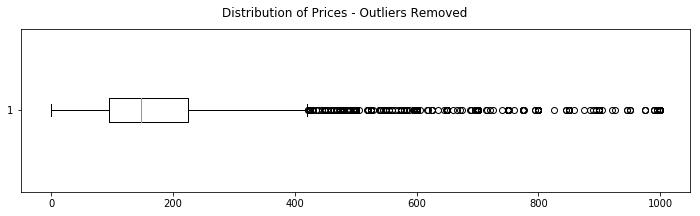

In [6]:
# there are a few outliers in regards to price per night. removing rentals over $1k per night

plt.rcParams['figure.figsize'] = 12,3
plt.figure().suptitle('Distribution of Prices')
plt.boxplot(listings['price'], vert=False)
plt.show()

listings = listings[listings['price']<1000.0]

plt.figure().suptitle('Distribution of Prices - Outliers Removed')
plt.boxplot(listings['price'], vert=False)
plt.show()

In [7]:
# check to make sure dates are correct. There are no records where the first review is greater than the last review.

[listings[listings['first_review'].isnull()==False] > listings[listings['last_review'].isnull()==False]] == True

False

In [8]:
# Airbnb was founded in August 2008. Two records are before August 2008, so they will be removed.

print('Records before August 2008: ', listings[listings['host_since']<'2008-08-01']['id'].count())
listings = listings[listings['host_since']>'2008-08-01']

Records before August 2008:  2


In [9]:
# when manually taking a look at the data, street did not seem to pass through correctly. We can still make sure 
# that all residences are in SF.
# remove all data not in SF
# South SF will sneak through based on the above logic. We will filter out South SF in particular

listings = listings[listings['street'].str.contains('San Francisco')]
listings = listings[~listings['street'].str.contains('South San Francisco')]

In [10]:
# some guests have never updated their calendar. This likely means they signed up to host, but never accepted a 
# reservation. we can remove them from the dataset

listings = listings[~listings['calendar_updated'].str.contains('never')]

In [11]:
# make sure listings are unique

listings['id'].nunique() / len(listings)

1.0

# Section 2: Data Exploration

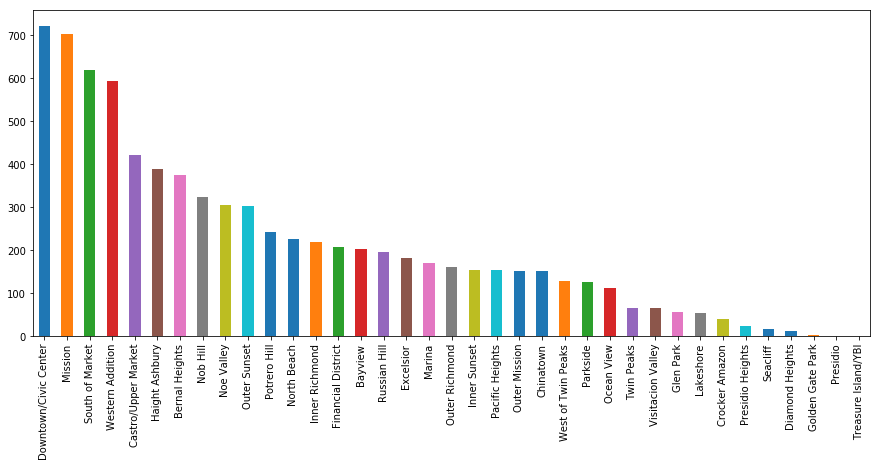

In [12]:
plt.rcParams['figure.figsize'] = 15,6
listings['neighbourhood_cleansed'].value_counts().plot(kind='bar')
plt.show()

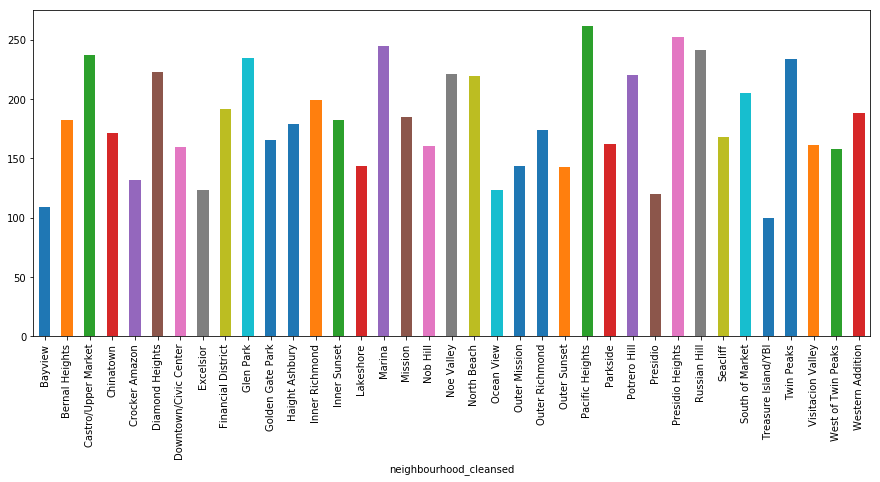

In [13]:
listings.groupby('neighbourhood_cleansed')['price'].mean().plot(kind='bar')
plt.show()

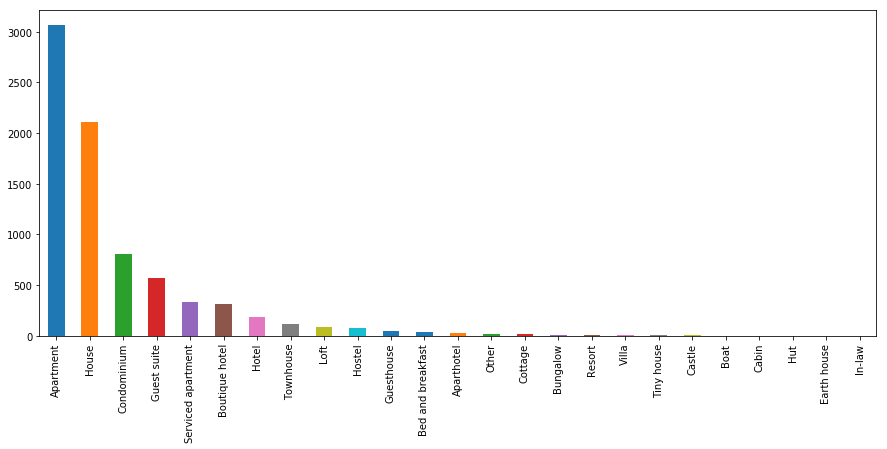

In [14]:
listings['property_type'].value_counts().plot(kind='bar')
plt.show()

/anaconda3/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


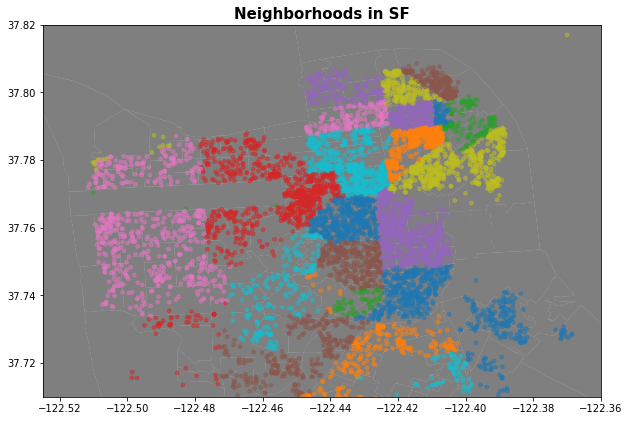

In [15]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

street_map = gpd.read_file('./geo_data/geo_export_6619bdbe-44d0-4fc6-b76f-276d186956e9.shp')

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]
geo_df = gpd.GeoDataFrame(listings,crs = crs, geometry = geometry)
fig, ax = plt.subplots(figsize=(10,10))
street_map.plot(ax=ax, alpha=0.5, color='black')
geo_df.plot(column='neighbourhood_cleansed', ax=ax,alpha=0.5, legend=False,markersize=14)
plt.title('Neighborhoods in SF', fontsize=15,fontweight='bold')
plt.xlim(-122.525, -122.36)
plt.ylim( 37.71, 37.82)
plt.show()

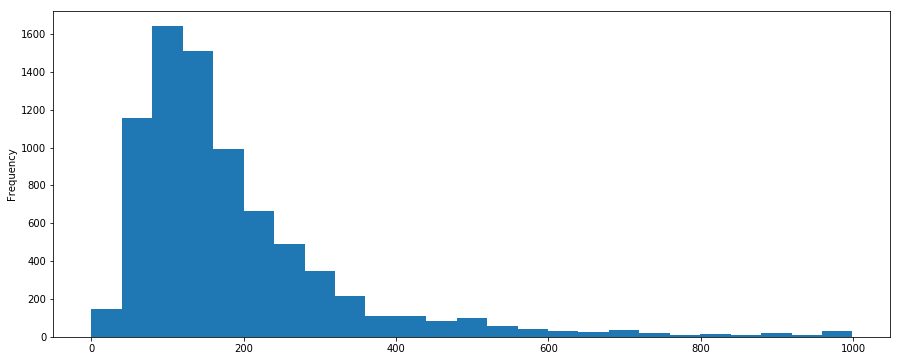

In [16]:
listings['price'].plot.hist(bins=25)
plt.show()